# PROJETO ANÁLISE - WEB SCRAPING - STEAM

## Descrição do objetivo do projeto


Jogadores e desenvolvedores de jogos muitas vezes têm dificuldade em identificar quais gêneros, estilos ou títulos estão em alta ou caindo em popularidade. Uma fonte poderosa desse tipo de informação é justamente o site da Steam, onde é possível descobrir:

- Quais são os jogos que mais estão em alta (maior publicidade do jogo no site)

- Quais são os jogos mais vendidos no momento em cada país 

- Quais são os gêneros de jogos mais recorrentes no ranking global

In [67]:
# !python3 -m pip install BeautifulSoup4==4.13.3
# !python3 -m pip install scikit-learn==1.6.1
# !python3 -m pip install selenium==4.29.0
# !python3 -m pip install webdriver_manager

## Etapas de execução do projeto

1) <a href="#carrossel">Captura dos jogos do carrossel do site</a>

2) <a href="#jogos_mais_vendidos_por_pais">Captura dos jogos mais vendidos por país: Mapa de Calor</a>

3) <a href="#precos_e_ofertas">Captura dos gêneros, preços e ofertas de jogos</a>

4) <a href="#generos_recorrencia">Identificando gêneros mais recorrentes: Wordcloud</a>

5) <a href="#analise_llm">API do Gemini: Adivinhação dos gêneros a partir da descrição</a>

## Instalando as dependências

In [151]:
# Imports necessários
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from functions import *
import pprint
import time
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import random

## Testes das funções auxiliares elaboradas: captura de gêneros 

In [69]:
# Testando funcionamento da função baixar página para um jogo qualquer
url = "https://store.steampowered.com/app/570940/DARK_SOULS_REMASTERED/"
pagina = baixar_pagina(url)

lista_generos = []
# Testando funcionamento da função extrair gênero para o mesmo jogo qualquer
extrair_genero(pagina, lista_generos)

['Souls-like',
 'Dark Fantasy',
 'RPG',
 'Difficult',
 'Action',
 'Dark',
 'Fantasy',
 'Atmospheric',
 'Great Soundtrack',
 'Action RPG',
 'Lore-Rich',
 'Adventure',
 'Multiplayer',
 'Exploration',
 'Story Rich',
 'Third Person',
 'Replay Value',
 'Character Customization',
 'Soundtrack',
 'Co-op']

## Inicializando o driver do Selenium

In [140]:
try:
    driver.quit()
    print('Fechando o driver')
except Exception as e:
    pass

print('Inicializando o driver')

# Inicializa o driver do Selenium
chrome_options = webdriver.ChromeOptions()
# chrome_options.add_argument('--headless') # ensure GUI is off
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
driver.set_page_load_timeout(60)

Fechando o driver
Inicializando o driver


## <div id="carrossel">Pega informação dos jogos do carrossel principal - "Destaque"</div>

In [141]:
# Pega pagina inicial da Steam
url = "https://store.steampowered.com/"
driver.get(url)
driver.implicitly_wait(10)

In [116]:
# Inicializa o Beautiful Soup
soup = BeautifulSoup(driver.page_source, 'html.parser')

carousel_items = {}

all_carousel = soup.find_all('a', class_="store_main_capsule")

g_id = 0
for game in all_carousel:
    g_name = game.find('div', class_="app_name").text
    g_reason = game.find('div', class_="reason").text
    href = game['href']

    carousel_items[g_id] = {
        'name': g_name,
        'page': href,
    }

    g_id += 1

pprint.pp(carousel_items)

{0: {'name': 'Dota 2',
     'page': 'https://store.steampowered.com/app/570/Dota_2/?snr=1_4_4__129_1'},
 1: {'name': 'eFootball™',
     'page': 'https://store.steampowered.com/app/1665460/eFootball/?snr=1_4_4__129_2'},
 2: {'name': 'Path of Exile 2',
     'page': 'https://store.steampowered.com/app/2694490/Path_of_Exile_2/?snr=1_4_4__129_3'},
 3: {'name': 'Project Zomboid',
     'page': 'https://store.steampowered.com/app/108600/Project_Zomboid/?snr=1_4_4__129_4'},
 4: {'name': '9 Kings',
     'page': 'https://store.steampowered.com/app/2784470/9_Kings/?snr=1_4_4__129_5'},
 5: {'name': 'Call of Duty®',
     'page': 'https://store.steampowered.com/app/1938090/Call_of_Duty/?snr=1_4_4__129_6'},
 6: {'name': 'Tom Clancy’s The Division® 2',
     'page': 'https://store.steampowered.com/app/2221490/Tom_Clancys_The_Division_2/?snr=1_4_4__129_7'},
 7: {'name': 'Sekiro™: Shadows Die Twice - GOTY Edition',
     'page': 'https://store.steampowered.com/app/814380/Sekiro_Shadows_Die_Twice__GOTY_Edit

In [117]:
# Transforma o dicionário em DataFrame
df_carrossel = pd.DataFrame.from_dict(carousel_items, orient='index')
df_carrossel.reset_index(drop=True, inplace=True)
df_carrossel.rename(columns={"name": "Jogo", "page": "Link", "status": "Disponibilidade"}, inplace=True)
df_carrossel

,Jogo,Link
0,Dota 2,https://store.steampowered.com/app/570/Dota_2/...
1,eFootball™,https://store.steampowered.com/app/1665460/eFo...
2,Path of Exile 2,https://store.steampowered.com/app/2694490/Pat...
3,Project Zomboid,https://store.steampowered.com/app/108600/Proj...
4,9 Kings,https://store.steampowered.com/app/2784470/9_K...
5,Call of Duty®,https://store.steampowered.com/app/1938090/Cal...
6,Tom Clancy’s The Division® 2,https://store.steampowered.com/app/2221490/Tom...
7,Sekiro™: Shadows Die Twice - GOTY Edition,https://store.steampowered.com/app/814380/Seki...
8,DayZ,https://store.steampowered.com/app/221100/DayZ...
9,F1® 25,https://store.steampowered.com/app/3059520/F1_...


## <div id="jogos_mais_vendidos_por_pais">Pega informação dos jogos mais vendidos por país</div>

In [82]:
# Pega pagina de jogos mais vendidos globalmente da Steam
url_mais_vendidos_global = "https://store.steampowered.com/charts/topselling/global"
driver.get(url_mais_vendidos_global)
driver.implicitly_wait(10)

In [85]:
# Testando captura dos jogos apenas para o ranking global
soup = BeautifulSoup(driver.page_source, 'html.parser')

top15_global = {}

all_games = soup.find_all('div', class_="_1n_4-zvf0n4aqGEksbgW9N")

limite = 15
for i, game in enumerate(all_games[:limite]):
    top15_global[i] = game.text
top15_global

{0: 'Counter-Strike 2',
 1: 'ELDEN RING NIGHTREIGN',
 2: 'Steam Deck',
 3: 'Stellar Blade™',
 4: 'Dune: Awakening',
 5: 'Red Dead Redemption 2',
 6: 'F1® 25',
 7: 'The Last of Us™ Part I',
 8: 'Clair Obscur: Expedition 33',
 9: 'The Elder Scrolls IV: Oblivion Remastered',
 10: 'FANTASY LIFE i: The Girl Who Steals Time',
 11: 'PUBG: BATTLEGROUNDS',
 12: 'Apex Legends™',
 13: 'Dota 2',
 14: 'POPUCOM'}

In [86]:
siglas_paises = {
    'Global': 'global', 
    'Alemanha': 'DE',
    'Austrália': 'AU',
    'Brasil': 'BR',
    'Bélgica': 'BE',
    'Canadá': 'CA',
    'China': 'CN',
    'Coreia do Sul': 'KR',
    'Dinamarca': 'DK',
    'Espanha': 'ES',
    'Estados Unidos': 'US',
    'Rússia': 'RU',
    'Finlândia': 'FI',
    'França': 'FR',
    'Hong Kong': 'HK',
    'Itália': 'IT',
    'Japão': 'JP',
    'Noruega': 'NO',
    'Nova Zelândia': 'NZ',
    'Países Baixos': 'NL',
    'Polônia': 'PL',
    'Reino Unido': 'GB',
    'República Tcheca': 'CZ',
    'Singapura': 'SG',
    'Suécia': 'SE',
    'Suíça': 'CH',
    'Tailândia': 'TH',
    'Taiwan': 'TW',
    'Turquia': 'TR',
    'Áustria': 'AT'
}

top15_por_pais = {}

for pais, sigla in siglas_paises.items():
    # print(f'Lendo página: {pais}')
    url_pais = f"https://store.steampowered.com/charts/topselling/{sigla}"
    driver.get(url_pais)    
    driver.implicitly_wait(10)

    time.sleep(1.7)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    all_games = soup.find_all('div', class_="_1n_4-zvf0n4aqGEksbgW9N")

    limite = 15
    dict_pais = {}
    for i, game in enumerate(all_games[:limite]):
        dict_pais[i] = game.text
        
    top15_por_pais[pais] = dict_pais

top15_por_pais

{'Global': {0: 'Counter-Strike 2',
  1: 'ELDEN RING NIGHTREIGN',
  2: 'Steam Deck',
  3: 'Stellar Blade™',
  4: 'Dune: Awakening',
  5: 'Red Dead Redemption 2',
  6: 'F1® 25',
  7: 'The Last of Us™ Part I',
  8: 'Clair Obscur: Expedition 33',
  9: 'The Elder Scrolls IV: Oblivion Remastered',
  10: 'FANTASY LIFE i: The Girl Who Steals Time',
  11: 'PUBG: BATTLEGROUNDS',
  12: 'Apex Legends™',
  13: 'Dota 2',
  14: 'POPUCOM'},
 'Alemanha': {0: 'Counter-Strike 2',
  1: 'ELDEN RING NIGHTREIGN',
  2: 'Steam Deck',
  3: 'F1® 25',
  4: 'Dune: Awakening',
  5: 'War Thunder',
  6: 'Red Dead Redemption 2',
  7: 'The Elder Scrolls IV: Oblivion Remastered',
  8: 'The Last of Us™ Part I',
  9: 'The Elder Scrolls® Online',
  10: 'RoadCraft',
  11: 'Stellar Blade™',
  12: 'Clair Obscur: Expedition 33',
  13: 'EA SPORTS FC™ 25',
  14: 'Tainted Grail: The Fall of Avalon'},
 'Austrália': {0: 'Counter-Strike 2',
  1: 'ELDEN RING NIGHTREIGN',
  2: 'Steam Deck',
  3: 'Dune: Awakening',
  4: 'The Elder Scro

In [87]:
# Verifica se algum pais ficou com jogos a menos
for pais, jogos in top15_por_pais.items():
    if len(jogos) < 15:
        print(f'Erro na leitura de: {pais}')

In [89]:
# Montando dataframe a partir do scraping feito
df_ranking = pd.DataFrame.from_dict(top15_por_pais, orient='index').transpose()
df_ranking['Ranking'] = [i for i in range(1, 16)]
cols = ['Ranking'] + [col for col in df_ranking.columns if col != 'Ranking']
df_ranking = df_ranking[cols]
df_ranking.head(3)

,Ranking,Global,Alemanha,Austrália,Brasil,Bélgica,Canadá,China,Coreia do Sul,Dinamarca,...,Polônia,Reino Unido,República Tcheca,Singapura,Suécia,Suíça,Tailândia,Taiwan,Turquia,Áustria
0,1,Counter-Strike 2,Counter-Strike 2,Counter-Strike 2,Counter-Strike 2,ELDEN RING NIGHTREIGN,ELDEN RING NIGHTREIGN,Counter-Strike 2,Stellar Blade™,Counter-Strike 2,...,Counter-Strike 2,Steam Deck,Counter-Strike 2,Counter-Strike 2,Counter-Strike 2,Counter-Strike 2,ELDEN RING NIGHTREIGN,Stellar Blade™,Counter-Strike 2,ELDEN RING NIGHTREIGN
1,2,ELDEN RING NIGHTREIGN,ELDEN RING NIGHTREIGN,ELDEN RING NIGHTREIGN,ELDEN RING NIGHTREIGN,F1® 25,Steam Deck,Stellar Blade™,PUBG: BATTLEGROUNDS,ELDEN RING NIGHTREIGN,...,ELDEN RING NIGHTREIGN,Counter-Strike 2,Steam Deck,ELDEN RING NIGHTREIGN,ELDEN RING NIGHTREIGN,ELDEN RING NIGHTREIGN,Counter-Strike 2,ELDEN RING NIGHTREIGN,ELDEN RING NIGHTREIGN,Counter-Strike 2
2,3,Steam Deck,Steam Deck,Steam Deck,Red Dead Redemption 2,Steam Deck,Counter-Strike 2,POPUCOM,ELDEN RING NIGHTREIGN,Dune: Awakening,...,Steam Deck,ELDEN RING NIGHTREIGN,ELDEN RING NIGHTREIGN,Dota 2,Steam Deck,F1® 25,Red Dead Redemption 2,Counter-Strike 2,Red Dead Redemption 2,F1® 25


c:\Users\PEDRO\OneDrive\Documentos\Insper\2025.1\ANALISE-FONTES-DESES\Steam_WebScraping\env\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 26143 (\N{CJK UNIFIED IDEOGRAPH-661F}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\PEDRO\OneDrive\Documentos\Insper\2025.1\ANALISE-FONTES-DESES\Steam_WebScraping\env\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20043 (\N{CJK UNIFIED IDEOGRAPH-4E4B}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\PEDRO\OneDrive\Documentos\Insper\2025.1\ANALISE-FONTES-DESES\Steam_WebScraping\env\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 32764 (\N{CJK UNIFIED IDEOGRAPH-7FFC}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\PEDRO\OneDrive\Documentos\Insper\2025.1\ANALISE-FONTES-DESES\Steam_WebScraping\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26143 (\N{CJK UNIFIED IDEOGRAPH-661F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, *

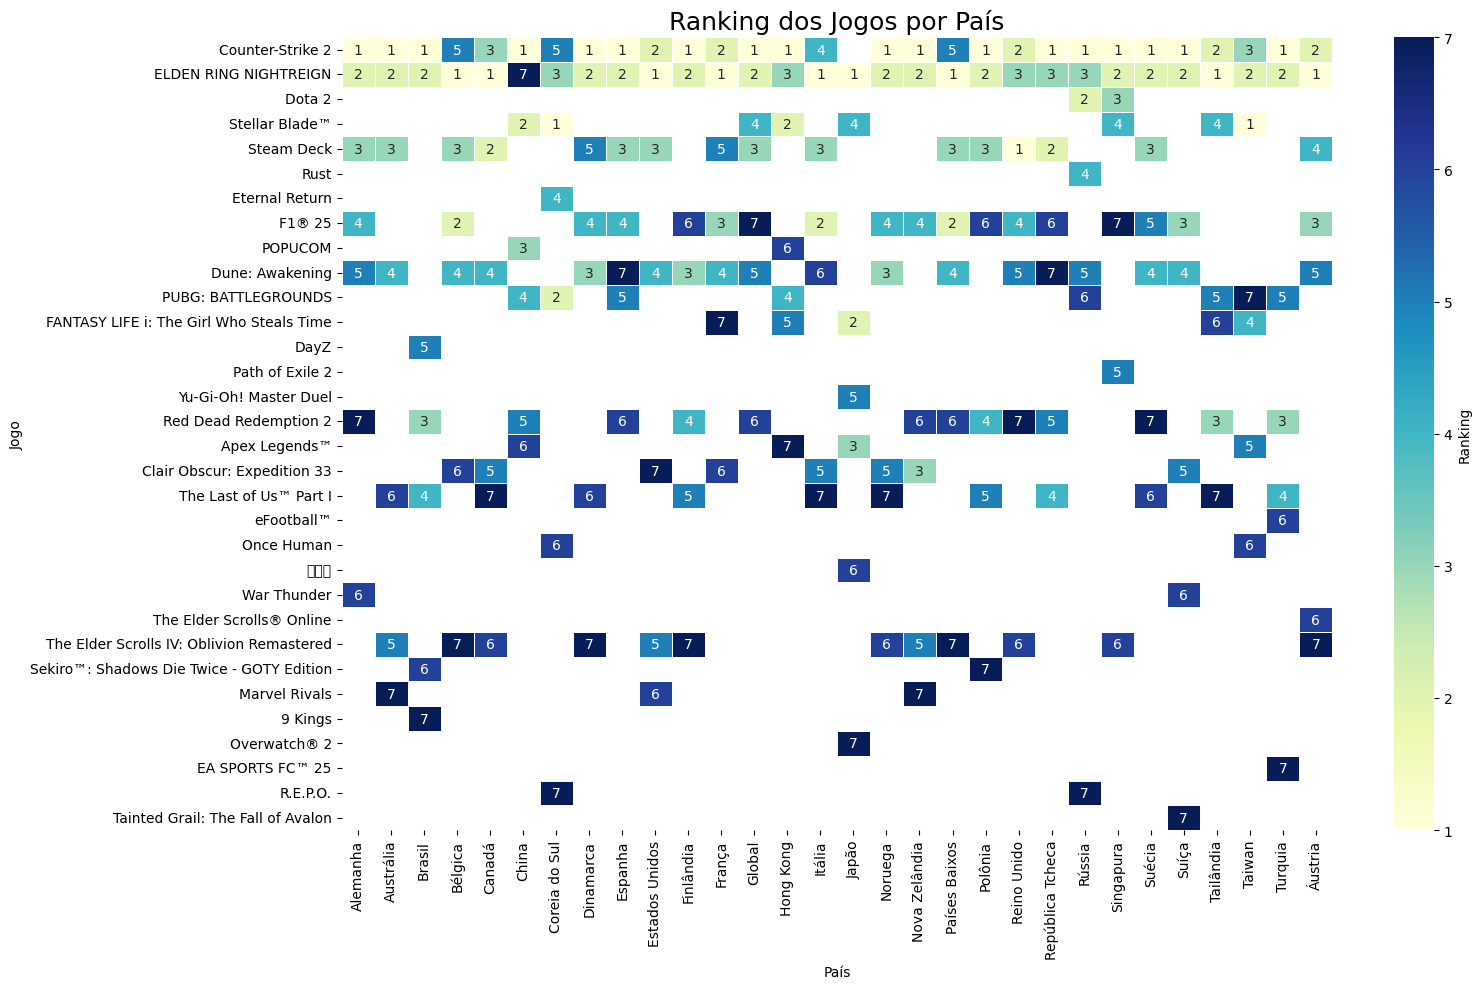

In [ ]:
df_top7 = df_ranking.iloc[:7, :] 

if 'Ranking' in df_top7.columns:
    df_top7 = df_top7.drop(columns=['Ranking'])

df_top7_long = df_top7.melt(var_name='País', value_name='Jogo')

df_top7_long['Ranking'] = df_top7_long.groupby('País').cumcount() + 1

heatmap_data = df_top7_long.pivot_table(index='Jogo', columns='País', values='Ranking')

heatmap_data['Média'] = heatmap_data.mean(axis=1)
heatmap_data = heatmap_data.sort_values('Média')
heatmap_data = heatmap_data.drop(columns='Média')

plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=.5, cbar_kws={'label': 'Ranking'})

plt.title('Ranking dos Jogos por País', fontsize=18)
plt.xlabel('País')
plt.ylabel('Jogo')
plt.tight_layout()
plt.show()

## Análise do Heat Map AQUI!!!

## <div id="precos_e_ofertas">Pega gêneros, preços e ofertas dos jogos - Top 15 global</div>

In [137]:
url_pais = f"https://store.steampowered.com/charts/topselling/global"
driver.get(url_pais)
driver.implicitly_wait(10)

botoes_jogos = driver.find_elements(By.CLASS_NAME, "_2-RN6nWOY56sNmcDHu069P")
jogos_generos = {}
lista_generos = []

count = 0
for i, _ in enumerate(botoes_jogos[:limite]):
    # if count == 5: 
    #     break

    time.sleep(2)
    botoes_jogos = driver.find_elements(By.CLASS_NAME, "_2-RN6nWOY56sNmcDHu069P")
    botoes_jogos[i].click()
    time.sleep(2)

    driver.implicitly_wait(10)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    # print(driver.current_url)

    if 'steamdeck' not in driver.current_url.split('/'):
        pagina = baixar_pagina(driver.current_url)
        top5_generos = extrair_genero(pagina, lista_generos)[0:4]

        # Automatiza colocar uma data de nascimento valida
        # Para jogos +18
        try:
            soup = BeautifulSoup(driver.page_source, 'html.parser')
            nome_jogo = soup.find('div', class_="apphub_AppName").text
        except Exception as e:
            # Insere data valida (1996)
            botao_1996 = driver.find_element(By.XPATH, '//*[@id="ageYear"]/option[97]')
            botao_1996.click()
            # Entra na pagina
            botao_ViewPage = driver.find_element(By.XPATH, '//*[@id="view_product_page_btn"]/span')
            botao_ViewPage.click()
            time.sleep(1)
            soup = BeautifulSoup(driver.page_source, 'html.parser')
            nome_jogo = soup.find('div', class_="apphub_AppName").text

        try:
            price = soup.find('div', class_="price").text.strip()
        except:
            price == soup.find('div', class_="discount_final_price").text.strip()

        # Verifica se tem está com desconto
        try:
            offer = soup.find('div', class_="discount_pct")
        except:
            pass

        status_offer = 1 if offer and price != "Gratuitos para Jogar" else 0
        # print(nome_jogo)
        # print(top5_generos)
        # print(f'   Preço: {price}')
        # print(f'   Status Offer: {status_offer}')
        # print()
        jogos_generos[nome_jogo] = {}
        jogos_generos[nome_jogo]["gêneros"] = top5_generos
        jogos_generos[nome_jogo]["preco"] = price
        jogos_generos[nome_jogo]["status_offer"] = status_offer
    else:
        count -= 1

    lista_generos = []
    top5_generos = []
    count += 1
    
    url_pais = f"https://store.steampowered.com/charts/topselling/global"
    driver.get(url_pais)
    driver.implicitly_wait(10)

In [ ]:
# Jogos, gêneros, preços e ofertas para dataframe
jogos_generos_top15 = {k: v['gêneros'] for k, v in jogos_generos.items() if len(v['gêneros']) > 0}
jogo_preco_status = {k: {'preco': v['preco'], 'status_offer': v['status_offer']} for k, v in jogos_generos.items() if len(v['gêneros']) > 0}
# Cria dataframe com os gêneros e preços dos jogos
df_jogos_top15 = pd.DataFrame.from_dict(jogos_generos_top15, orient='index').reset_index()
df_jogos_top15.columns = ['Jogo'] + [f'Gênero {i+1}' for i in range(df_jogos_top15.shape[1] - 1)]
# Preço e status de oferta
df_jogos_top15['Preço'] = [jogo_preco_status[jogo]['preco'] for jogo in df_jogos_top15['Jogo']]
df_jogos_top15['Status Oferta'] = [jogo_preco_status[jogo]['status_offer'] for jogo in df_jogos_top15['Jogo']]

In [139]:
df_jogos_top15

,Jogo,Gênero 1,Gênero 2,Gênero 3,Gênero 4,Preço,Status Oferta
0,Counter-Strike 2,FPS,Shooter,Multiplayer,Competitive,Gratuitos para Jogar,0
1,ELDEN RING NIGHTREIGN,Souls-like,Online Co-Op,Roguelike,Multiplayer,"R$ 197,90",0
2,Dune: Awakening,Open World Survival Craft,Adventure,Massively Multiplayer,Third Person,"R$ 179,00",0
3,F1® 25,Racing,Sports,Simulation,PvP,"R$ 249,00",0
4,Red Dead Redemption 2,Open World,Story Rich,Western,Adventure,"R$ 299,90",0
5,Clair Obscur: Expedition 33,Turn-Based Combat,Story Rich,Fantasy,RPG,"R$ 199,00",0
6,The Elder Scrolls IV: Oblivion Remastered,RPG,Open World,Fantasy,Singleplayer,"R$ 45,81",1
7,The Last of Us™ Part I,Story Rich,Post-apocalyptic,Zombies,Shooter,"R$ 249,90",0
8,Dota 2,Free to Play,MOBA,Multiplayer,Strategy,Gratuito para jogar,1
9,FANTASY LIFE i: The Girl Who Steals Time,RPG,Action,Casual,JRPG,"R$ 299,90",0


## <div id="generos_recorrencia">Identificando os gêneros mais recorrentes</div>

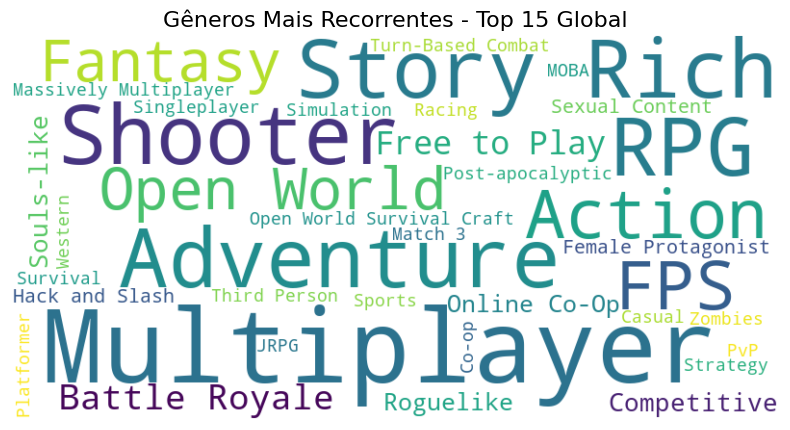

In [ ]:
def gerar_wordcloud_generos(df, titulo):
    colunas_genero = ['Gênero 1', 'Gênero 2', 'Gênero 3', 'Gênero 4']
    
    generos = df[colunas_genero].values.flatten()
    generos = [g for g in generos if g not in [None, 'None']]
    
    contador = Counter(generos)
    
    wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis')
    wc.generate_from_frequencies(contador)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo, fontsize=16)
    plt.show()

gerar_wordcloud_generos(df_jogos_top15, "Gêneros Mais Recorrentes - Top 15 Global")

## Análise do Wordcloud AQUI!!!

## <div id="analise_llm">API do Gemini: Um LLM é capaz de descobrir os principais gêneros de um jogo a partir de sua descrição?</div>

In [ ]:
url_pais = f"https://store.steampowered.com/charts/topselling/global"
driver.get(url_pais)
driver.implicitly_wait(10)

# Escolhe aleatoriamente dez jogos do ranking global
ocorridos = []
i = 0
while i < 10:
    num = random.randint(1, 95)
    if i not in ocorridos:
        ocorridos.append(num)
        i += 1

        botoes_jogos = driver.find_elements(By.CLASS_NAME, "_2-RN6nWOY56sNmcDHu069P")
        jogo = botoes_jogos[num].text.split('\n')[1]
        print(f'Jogo escolhido: {jogo} - Número: {num}')
        # botoes_jogos[num].click()        

Jogo escolhido: Phasmophobia - Número: 93
Jogo escolhido: Warhammer 40,000: Space Marine 2 - Número: 30
Jogo escolhido: Overwatch® 2 - Número: 60
Jogo escolhido: Monster Train 2 - Número: 71
Jogo escolhido: Baldur's Gate 3 - Número: 37
Jogo escolhido: Tom Clancy's Rainbow Six® Siege - Número: 33
Jogo escolhido: Arma Reforger - Número: 72
Jogo escolhido: The Elder Scrolls V: Skyrim Special Edition - Número: 36
Jogo escolhido: REMATCH - Número: 31
Jogo escolhido: Warframe - Número: 25
